In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl as px

## Data Pre-processing

In [41]:
AAPL = pd.read_excel("./data/AAPL_EQUITY.xlsx")
SPESG = pd.read_excel(('./data/SPESG_Index_5Y.xlsx')).dropna()

# Take SPESG and AAPL and combine them into one data frame: df['Date', 'SPESG', 'AAPL_Px', 'AAPL_Volume', 'AAPL_SMAVG(15)']
df = pd.merge(AAPL, SPESG, on='Date', how='inner')
new_columns = {'Last Px_x' : 'AAPL_Px', 'Volume': 'AAPL_Volume(M)', 'SMAVG(15)' : 'AAPL_SMAVG15(M)', 'Last Px_y': 'SPESG'}
df.rename(columns=new_columns, inplace=True)
df = df.dropna()
# Strip M and convert these columns from object into float64
df['AAPL_Volume(M)'] = df['AAPL_Volume(M)'].str.strip('M').astype('float64')
df['AAPL_SMAVG15(M)'] = df['AAPL_SMAVG15(M)'].str.strip('M').astype('float64')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.strftime('%A')
df

,Date,AAPL_Px,AAPL_Volume(M),AAPL_SMAVG15(M),SPESG,Year,Quarter,Month,Day
0,2024-04-26,169.520,25.946,56.944,453.52,2024,2,4,Friday
1,2024-04-25,169.890,50.558,58.021,446.47,2024,2,4,Thursday
2,2024-04-24,169.020,48.252,58.231,447.28,2024,2,4,Wednesday
3,2024-04-23,166.900,49.538,58.193,446.95,2024,2,4,Tuesday
4,2024-04-22,165.840,48.116,58.179,441.80,2024,2,4,Monday
...,...,...,...,...,...,...,...,...,...
1255,2019-05-02,52.287,127.985,108.815,242.00,2019,2,5,Thursday
1256,2019-05-01,52.630,259.309,106.068,242.55,2019,2,5,Wednesday
1257,2019-04-30,50.167,186.140,98.319,244.34,2019,2,4,Tuesday
1258,2019-04-29,51.153,88.819,92.811,243.59,2019,2,4,Monday


## Calculate returns

In [42]:
ret_period = [1, 5, 10, 30, 60, 120, 250]
for p in ret_period:
    df[f'AAPL_Px_ret{p}'] = ((df['AAPL_Px'] - df['AAPL_Px'].shift(-p)) / df['AAPL_Px'].shift(-p)).round(4)

df['AAPL_ret_f1'] = df['AAPL_Px_ret1'].shift(-1)

# Calculate the 100-day moving average
df['AAPL_Px_100MA'] = df['AAPL_Px'].shift(-100).rolling(window=100).mean()
df['AAPL_Px_50MA'] = df['AAPL_Px'].shift(-50).rolling(window=50).mean()
df['AAPL_Px_10MA'] = df['AAPL_Px'].shift(-10).rolling(window=10).mean()

weekday_dummies = pd.get_dummies(df['Day']).astype(int)
df = pd.concat([df, weekday_dummies], axis=1)

In [43]:
df.head()

,Date,AAPL_Px,AAPL_Volume(M),AAPL_SMAVG15(M),SPESG,Year,Quarter,Month,Day,AAPL_Px_ret1,...,AAPL_Px_ret250,AAPL_ret_f1,AAPL_Px_100MA,AAPL_Px_50MA,AAPL_Px_10MA,Friday,Monday,Thursday,Tuesday,Wednesday
0,2024-04-26,169.52,25.946,56.944,453.52,2024,2,4,Friday,-0.0022,...,-0.0009,0.0051,NaN,NaN,NaN,1,0,0,0,0
1,2024-04-25,169.89,50.558,58.021,446.47,2024,2,4,Thursday,0.0051,...,0.0088,0.0127,NaN,NaN,NaN,0,0,1,0,0
2,2024-04-24,169.02,48.252,58.231,447.28,2024,2,4,Wednesday,0.0127,...,0.0321,0.0064,NaN,NaN,NaN,0,0,0,0,1
3,2024-04-23,166.90,49.538,58.193,446.95,2024,2,4,Tuesday,0.0064,...,0.0191,0.0051,NaN,NaN,NaN,0,0,0,1,0
4,2024-04-22,165.84,48.116,58.179,441.80,2024,2,4,Monday,0.0051,...,0.0031,-0.0122,NaN,NaN,NaN,0,1,0,0,0


## Data splitting
Temoral Train/test split

In [44]:
df.sort_values(by='Date', ascending=True, inplace=True)

split_ts = pd.Timestamp("2021-04-06")
training_set = df[df['Date'] <= split_ts]
holdout_set = df[df['Date'] > split_ts]

## Return Analysis

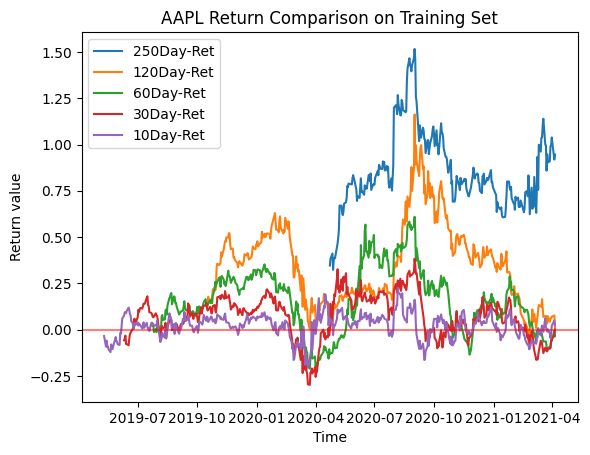

In [59]:
empty_row = training_set.isna().any(axis=1)
plt.plot(training_set['Date'], training_set['AAPL_Px_ret250'], label="250Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret120'], label="120Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret60'], label="60Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret30'], label="30Day-Ret")
plt.plot(training_set['Date'], training_set['AAPL_Px_ret10'], label="10Day-Ret")
plt.axhline(y=0, color="red", alpha=0.5)

plt.legend()
plt.title("AAPL Return Comparison on Training Set")
plt.xlabel("Time")
plt.ylabel("Return value")
plt.show()

**Conclusion** <br>
We can't choose linear regression or other interpolation method to fill the empty ret250 cells, since the 250-Day return seems fluctuating too much.

# Feature Engineering

In [45]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df = training_set.dropna()
X = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
y = df['AAPL_ret_f1']

# Define a list of feature combinations to try
feature_combinations = [
    ['AAPL_Px'],
    ['AAPL_Px_ret1', 'AAPL_Px_ret5', 'AAPL_Px_ret10', 'AAPL_Px_ret30', 'AAPL_Px_ret60', 'AAPL_Px_ret120', 'AAPL_Px_ret250'],
    ['Year', 'Quarter', 'Month', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    # Add more feature combinations as needed
]

regressor = RandomForestRegressor()
# Train and evaluate the model for each feature combination
for i, features in enumerate(feature_combinations):
    X_subset = X[features]
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.4, random_state=42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    r_squared = r2_score(y_test, y_pred)
    print(f"Feature Combination {i + 1}: {features} - R-squared: {r_squared}")

ValueError: Input y contains NaN.

# Modeling

### Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


# We should re-read the df, since we fit the model in feature engineering section 
df = training_set.dropna()
X = df.drop(['Date', 'Day', 'Year', 'AAPL_ret_f1'], axis=1)
y = df['AAPL_ret_f1']

# Create Random Forest Regressor object
regressor = RandomForestRegressor()

cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='r2')

# Evaluation & Measurement
## Model evaluation

In [37]:
print(cv_scores)

           Date  AAPL_Px  AAPL_Volume(M)  AAPL_SMAVG15(M)   SPESG  Year  \
1009 2020-04-23   68.757         124.814          160.931  237.96  2020   
1008 2020-04-24   70.743         126.509          158.302  241.33  2020   
1007 2020-04-27   70.793         117.088          157.449  244.93  2020   
1006 2020-04-28   69.645         112.005          151.462  243.43  2020   
1005 2020-04-29   71.933         137.281          147.088  250.08  2020   

      Quarter  Month        Day  AAPL_Px_ret1  ...  AAPL_Px_ret250  \
1009        2      4   Thursday       -0.0039  ...          0.3462   
1008        2      4     Friday        0.0289  ...          0.3830   
1007        2      4     Monday        0.0007  ...          0.4111   
1006        2      4    Tuesday       -0.0162  ...          0.3233   
1005        2      4  Wednesday        0.0329  ...          0.3757   

      AAPL_ret_f1  AAPL_Px_100MA  AAPL_Px_50MA  AAPL_Px_10MA  Friday  Monday  \
1009       0.0288       71.49775      68.95486  

## Strategy performance measurement
### Metrics
**Sharpe ratio, Maximum Dropdown, Alpha and Beta**

Daily Sharpe Ratio: 0.06877949987336085
Annualized Sharpe Ratio: 1.091840711785868


### Equity Graph